# Analyse des occupations   

In [22]:
### Librairies externes à ajouter le cas échéant à l'environnement Python actif

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

### Librairies déjà installées avec Python

import pprint
import csv
import sys

from importlib import reload



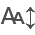

In [23]:
### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [24]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## Importer les donnée à analyser

In [25]:
## define SPARQL enpoint
endpoint = "https://ag16vva57r0v2dln.allegrograph.cloud/repositories/nobel-laureats"

In [26]:
### Get and count persons occupations

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?occupation ?occupationLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {?item wdt:P106 ?occupation.
        ?occupation rdfs:label ?occupLabel
        BIND(LCASE(?occupLabel) as ?occupationLabel)    
          }
}
GROUP BY ?occupation ?occupationLabel 
ORDER BY DESC(?n)
#LIMIT 30
"""

In [27]:
### Execute the query using the local custom fonctions
qr = spqf.get_json_sparql_result(endpoint,query)

In [28]:
### Count and inspect the available occupations
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

263


[['http://www.wikidata.org/entity/Q1622272', 'university teacher', '476'],
 ['http://www.wikidata.org/entity/Q169470', 'physicist', '282'],
 ['http://www.wikidata.org/entity/Q593644', 'chemist', '266']]

In [29]:
### Transform the results into a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q1622272,university teacher,476
1,http://www.wikidata.org/entity/Q169470,physicist,282
2,http://www.wikidata.org/entity/Q593644,chemist,266
3,http://www.wikidata.org/entity/Q39631,physician,151
4,http://www.wikidata.org/entity/Q2919046,biochemist,149


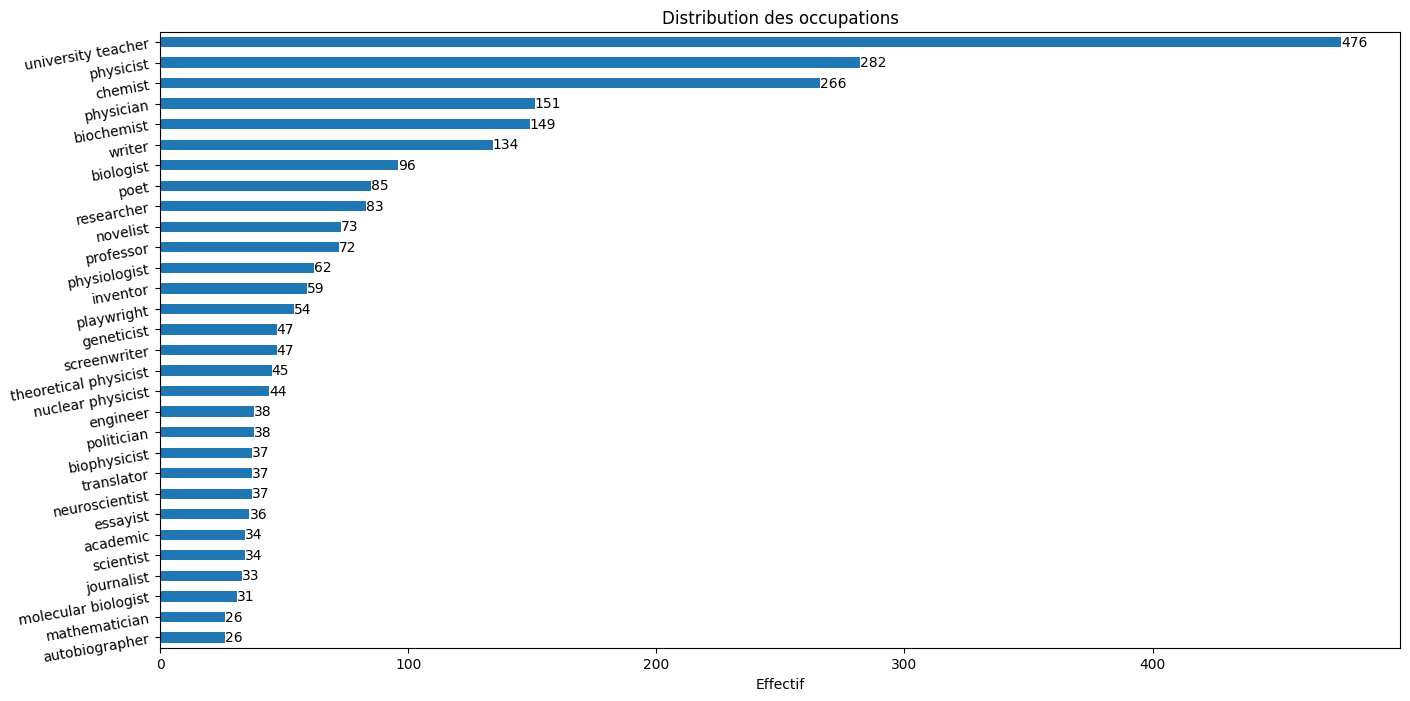

In [30]:
### Bar chart showing distribution by 'occupation': 
# 30 most frequent occupations
ax = df_r['effectif'].head(30).sort_values(ascending=True)\
    .plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(df_r.head(30).label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

In [31]:
l= len(df_r[df_r['effectif'] == 1])
print(l)

125


In [32]:
l= len(df_r[df_r['effectif'] < 10])
print(l)

211


**Comment**: There is a remarkable difference between the first three occupational categories compared to the others.

There are 125 occupations with only one person and 211 with less than 10 persons, for a total of 263 different occupations.

### Graphically represent the frequency distribution

There is a wide dispersion of values and a predominant position for activities involving 10 or fewer people

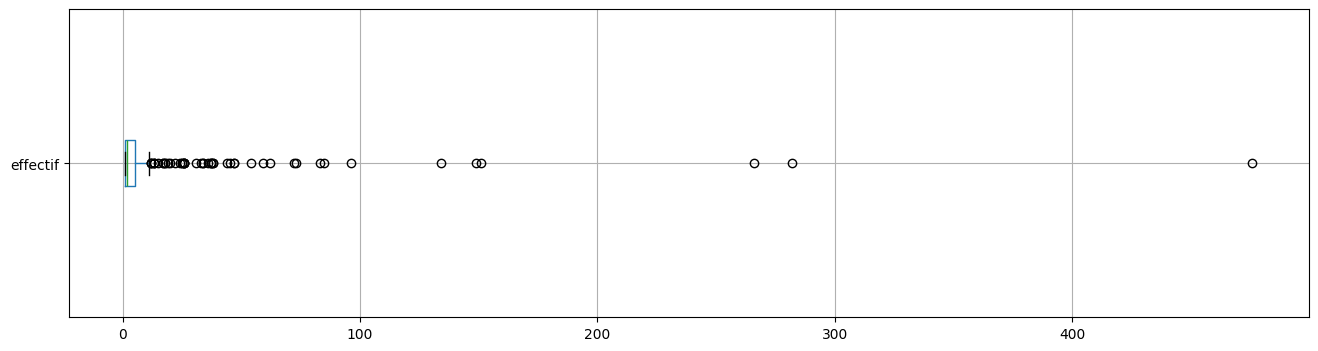

In [33]:
### Distribution des effectifs par occupation
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

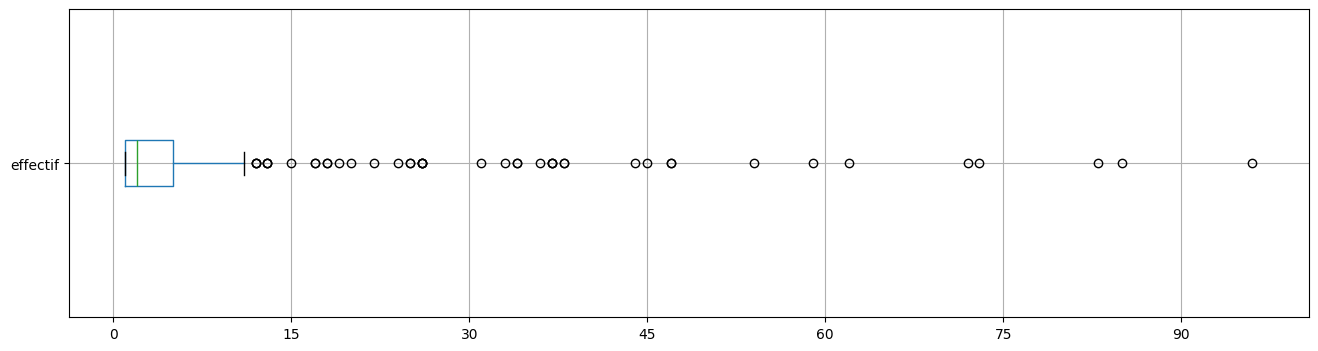

In [34]:
### Distribution des effectifs par occupation
ax = df_r[df_r.effectif<100].boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

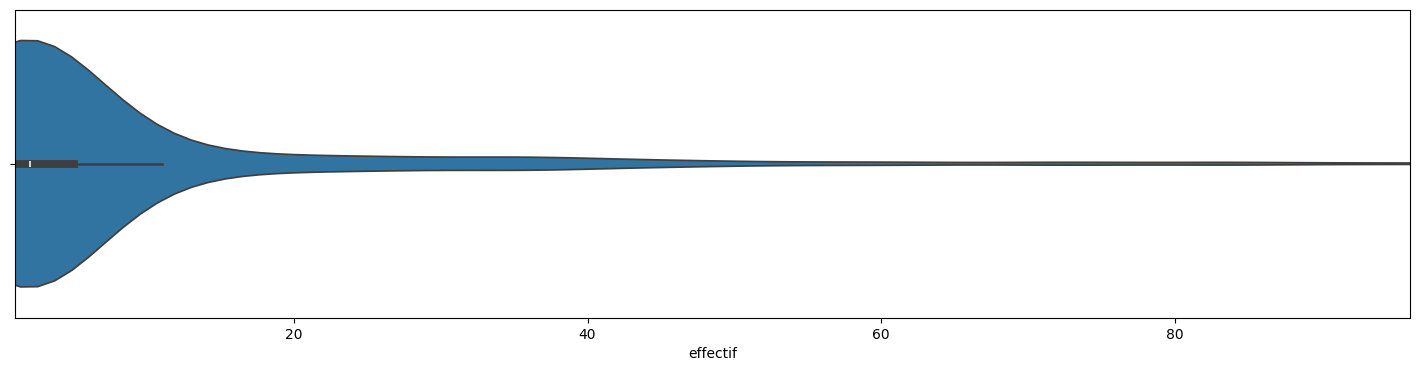

In [35]:
### Represent the density (the total surface has frequency = 1)
# https://seaborn.pydata.org/generated/seaborn.violinplot.html

plt.figure(figsize=(18,4))
d = df_r[df_r.effectif<100].effectif

ax = sns.violinplot(x = d)


### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(d), right=max(d))
plt.show()

### Group by frequency range

In [36]:
### Set the thresholds

ls = [1, 5, 10, 20, 50, 100, 200, 300, 500] 
print(ls)

[1, 5, 10, 20, 50, 100, 200, 300, 500]


In [37]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['seuils'] = pd.cut(df_r['effectif'], ls, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['seuils'] = df_r['seuils'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,uri,label,effectif,seuils
0,http://www.wikidata.org/entity/Q1622272,university teacher,476,300-499
1,http://www.wikidata.org/entity/Q169470,physicist,282,200-299
2,http://www.wikidata.org/entity/Q593644,chemist,266,200-299


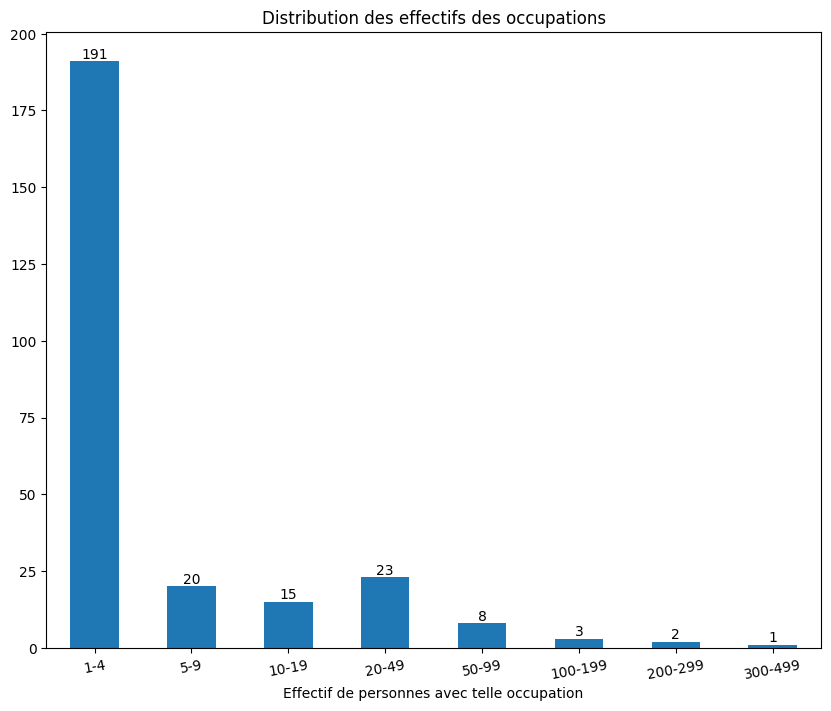

In [38]:
# Plot the grouped distribution

ax = df_r.groupby(by='seuils', observed=False).size()\
    .plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

### Inspect the values

In [39]:
print(df_r[df_r['effectif'] == 1].head(10).label)

138                 otologist
139    experimental physicist
140         classical scholar
141                 urologist
142    conscientious objector
143                  mechanic
144               philologist
145                   scholar
146             lexicographer
147                 germanist
Name: label, dtype: object


In [40]:
print(df_r[df_r['effectif'] == 5].head(10).label)

64                           esperantist
65                    computer scientist
66             french resistance fighter
67                            biographer
68                             historian
69                                 actor
70                             internist
71    artificial intelligence researcher
Name: label, dtype: object


In [41]:
print(df_r[df_r['effectif'] == 10].head(10).label)

51    pedagogue
Name: label, dtype: object


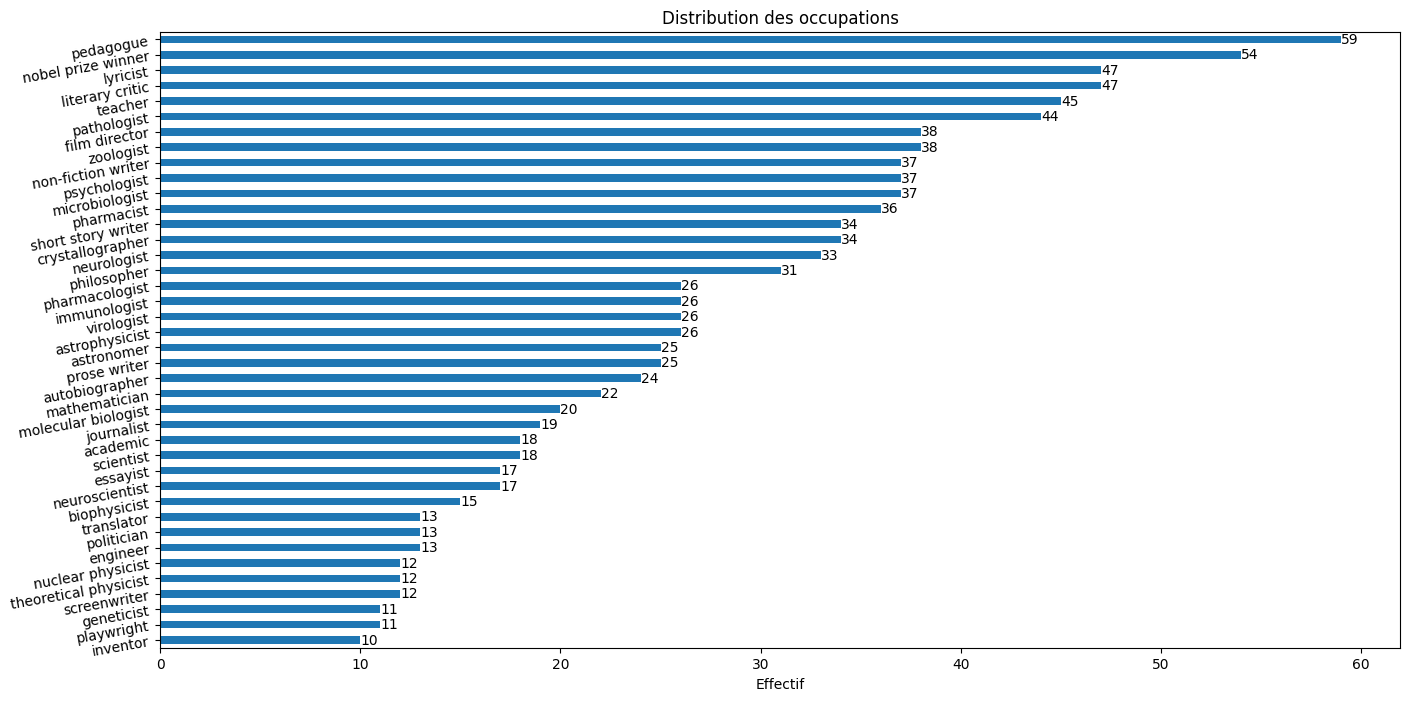

In [42]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[(df_r.effectif < 100)&(df_r.effectif > 9)].sort_values(by='effectif',ascending=True).head(40)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

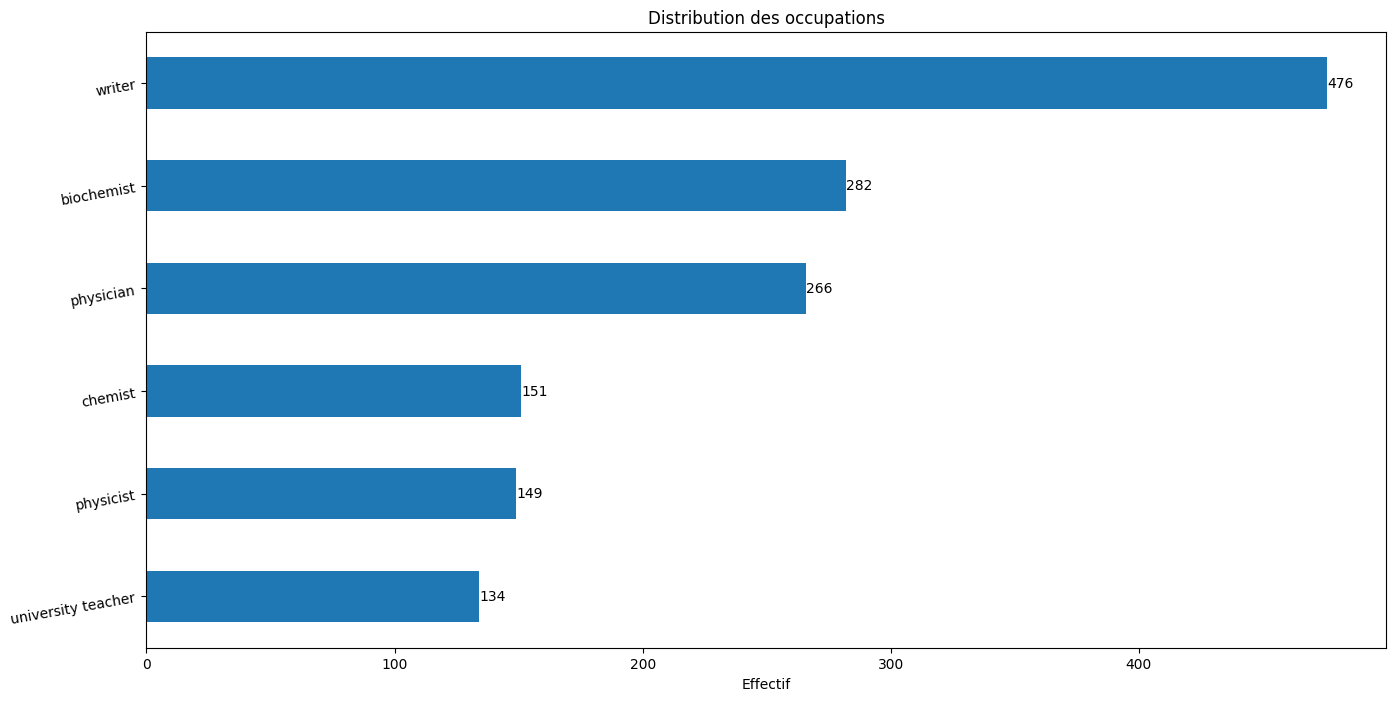

In [43]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[df_r.effectif > 100].sort_values(by='effectif',ascending=True)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

**Comment**

Observation of the typology of occupations reveals a variety that leads to two different types of questions: 
* the specificities of profiles within scientific disciplines
* other activities (artistic, economic, etc.) in their relationship with the disciplines


The aim will be to better define the question or questions we wish to address and to use the information available in Wikidata to create classes.


Another question we could raise is the *changing distribution and configuration over tim*e.

Another question we could ask is the changing distribution and configuration over time. To answer this question, we should add the birth years or generations of the individuals to the characteristics of the occupations.


## Explore the number of occupations per person

In [44]:
### Basic query regarding persons' occupations

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item ?itemLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {?item wdt:P106 ?occupation.
        OPTIONAL {?item rdfs:label ?itemLabel}    
          }
}
GROUP BY ?item ?itemLabel
ORDER BY DESC(?n)
LIMIT 500
"""

In [45]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [46]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

500


[['http://www.wikidata.org/entity/Q765', 'Dario Fo', '19'],
 ['http://www.wikidata.org/entity/Q7241', 'Rabindranath Tagore', '19'],
 ['http://www.wikidata.org/entity/Q392', 'Bob Dylan', '18']]

In [47]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q765,Dario Fo,19
1,http://www.wikidata.org/entity/Q7241,Rabindranath Tagore,19
2,http://www.wikidata.org/entity/Q392,Bob Dylan,18
3,http://www.wikidata.org/entity/Q33760,Bertrand Russell,18
4,http://www.wikidata.org/entity/Q5878,Gabriel García Márquez,15


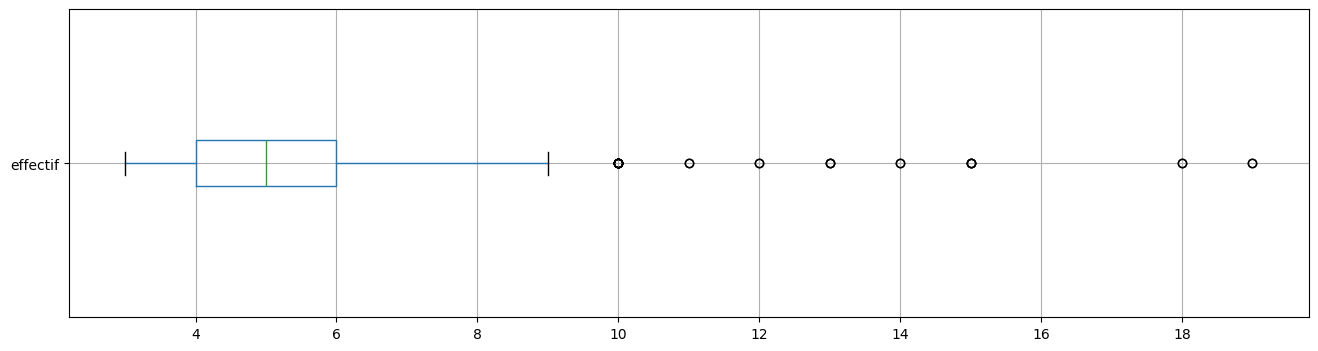

In [48]:
### Distribution of frequencies per person
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

## this fuction avoids ticks with floats instead of integers
#  on the x axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

**Comment**

Most persons have between 4 and 6 occupations, with some outliers

47


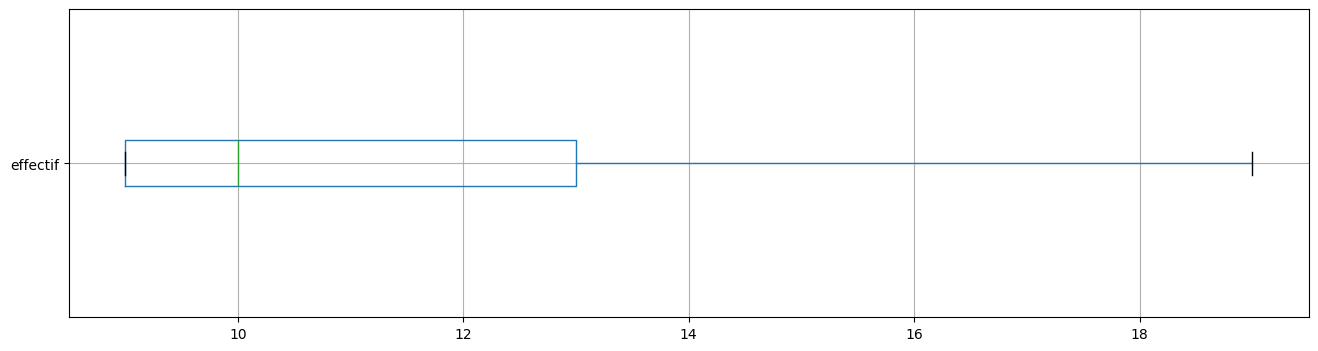

In [49]:
### Distribution des effectifs par occupation

d = df_r[df_r.effectif > 8]
print(len(d))

ax = d.boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [50]:
### Cf. the profiles of these persons in Wikidata
pprint.pprint(d.tail())

                                      uri            label  effectif
42   http://www.wikidata.org/entity/Q7176   Naguib Mahfouz         9
43  http://www.wikidata.org/entity/Q12658  Wilhelm Ostwald         9
44  http://www.wikidata.org/entity/Q39246  Richard Feynman         9
45  http://www.wikidata.org/entity/Q41042    Harold Pinter         9
46  http://www.wikidata.org/entity/Q42443   Anatole France         9


## Parent occupations

We can try to use the taxonomy of occupations to select relevant occupations.

We therefore go back to the [Import sparqlbook](../../sparqlbooks/wdt_import_occupations.sparqlbook)

In [51]:
query = """
## 

### Simplified query

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT DISTINCT 
?occupation ?occupationLabel ?parentField ?parentFieldLabel
?n
          #?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
          # (SUM(?n) as ?sn)
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {
          SELECT ?occupation ?occupationLabel
          ?parentOccupation (COUNT(*) as ?n)
        
        WHERE
        {
          ?s a wd:Q5;  
              wdt:P106 ?occupation.
          ?occupation rdfs:label ?occupationLabel.
          ?occupation  wdt:P279  ?parentOccupation.
          }  
        GROUP BY ?occupation ?occupationLabel
          ?parentOccupation
        }

        SERVICE <https://query.wikidata.org/sparql>
          {
              # field of parent occupation / instance of /  subclass of  
              ?parentOccupation wdt:P425 / wdt:P31 ?parentField.
              # ?parentField wdt:P279 ?parentKnowledgeClassification.


              #BIND (?occupation as ?occupationLabel)
              BIND (?parentFieldLabel as ?parentFieldLabel)
              # BIND (?parentKnowledgeClassificationLabel as ?parentKnowledgeClassificationLabel)
              SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } 
          }

}
# GROUP BY ?occupation ?occupationLabel ?parentField ?parentFieldLabel
          # ?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
ORDER BY DESC(?n)
"""

In [52]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [53]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

872


[['http://www.wikidata.org/entity/Q1622272',
  'university teacher',
  'http://www.wikidata.org/entity/Q2465832',
  'branch of science',
  '476'],
 ['http://www.wikidata.org/entity/Q1622272',
  'university teacher',
  'http://www.wikidata.org/entity/Q26256810',
  'topic',
  '476'],
 ['http://www.wikidata.org/entity/Q1622272',
  'university teacher',
  'http://www.wikidata.org/entity/Q130303173',
  'service type',
  '476']]

In [54]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uriOccupation', 'labelOccupation', 'uriDomaine', 'labelDomain', 'size']
# df_r['size'] = df_r.size.apply(lambda x : int(x))
df_r.head()

,uriOccupation,labelOccupation,uriDomaine,labelDomain,size
0,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q2465832,branch of science,476
1,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q26256810,topic,476
2,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q130303173,service type,476
3,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q151885,concept,476
4,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q1914636,activity,476


In [ ]:

## [gb_oc['size'] > 4 ]

show(df_r,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", 
     columnDefs=[{"className": "dt-left", "targets": "_all"}],
     #search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

In [ ]:
query = """
### Occupation classifications

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?birthYear ?o ?oLabel ?oP ?oPLabel
WHERE {
    GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
        {?item a wd:Q5;
            wdt:P569 ?birthYear;
            wdt:P106 ?o.
        ?o a wd:Q12737077;
            wdt:P279 ?o1.
        OPTIONAL {?o rdfs:label ?oLabel}    
        OPTIONAL {?oP rdfs:label ?oPLabel}    
          }
}
ORDER BY ?s
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
#qr = spqf.get_json_sparql_result(endpoint,query)

In [ ]:
'''r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]'''

In [ ]:
'''### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['year', 'oc_uri', 'oc_label', 'op_uri', 'op_label']
df_r['year'] = df_r.year.apply(lambda x : int(x))
df_r.head()'''

### Codage par période de cinquante ans

In [ ]:
### Créer une liste d'années pour séparer en périodes de 50 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 

l_25 = list(range(1751, 2001, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)
print("hhh")

In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['per_25'] = pd.cut(df_r['year'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['per_25'] = df_r['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

In [ ]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

In [ ]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

In [ ]:
### distribution des naissances par périodes de 25 ans
gb_oc = df_r.groupby(by=['oc_label','op_label'], observed=False, as_index=False).size()
print(len(gb_oc))
gb_oc.head()

In [ ]:

## [gb_oc['size'] > 4 ]

show(gb_oc.sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

# La suite est en préparation

## Paires d'occupations

In [ ]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>

## Pour avoir les données avec la personne et l'effectif de toutes les relations
# SELECT DISTINCT ?item ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label

SELECT ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label
WHERE
  {GRAPH <https://github.com/VericaD/nobel_laureates_pc/blob/main/graph/wikidata-imported-data.md>
     {
      ?item wdt:P106 ?occupation.
      ?item wdt:P106 ?occupation_1.
      ?occupation rdfs:label ?occupationLabel.
      ?occupation_1 rdfs:label ?occupation_1Label.
      FILTER (str(?occupationLabel) < str(?occupation_1Label))
      } 

      }
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [ ]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

In [ ]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'uri_1', 'label1_']
df_r.uri = df_r.uri.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.uri_1 = df_r.uri_1.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.head()

In [ ]:
list(df_r.columns)

In [ ]:
gr = pd.DataFrame(df_r.groupby(['uri', 'label', 'uri_1', 'label1_']).size())
gr.reset_index(inplace=True)
gr.columns=list(df_r.columns)+['size']
gr.sort_values(by='size', ascending=False).head(40)

In [ ]:
gr.sort_values(by='size', ascending=False).tail(40)

In [ ]:
### Distribution des effectifs par occupation
ax = gr.boxplot(column=['size'], vert=False, figsize=(16,4))

In [ ]:
### Distribution des effectifs par occupation
ax = gr[(gr['size']>10) & (gr['size']<500)].boxplot(column=['size'], vert=False, figsize=(16,4))

In [ ]:
ax = gr['size'].plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

In [ ]:
plt.figure(figsize=(15, 4))
d = gr[(gr['size'] > 0) & (gr['size'] < 10)]['size']
#d = gr['size']


ax = sns.barplot(x = d)
ax.set_xlim(left=min(d), right=max(d))

ax.plot()

In [ ]:
show(gr[gr['size'] > 4 ].sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)